In [1]:
# Title: DMRG for Bachelor Thesis
# Author: Aaron Sander
# Date: March-April 2020

# This program is used for initial learning of tensor network methods
# to be used in my bachelor thesis.
# It is an implementation of Matrix Product States (MPS) and Density Matrix
# Renormalization Group (DMRG) for compressing an arbitrary quantum state
# which has relevant applications in data compression and graph embedding.

### NOTE: This code is written for learning purposes. It is not meant
###       to be optimized for speed/efficiency, but has readability in mind.

In [2]:
######################### IMPORTS #############################################
import numpy as np
import random as rand
import csv
import matplotlib.pyplot as plt
import math

In [3]:
######################## INITIALIZATIONS ##############################################
def initialize_random_state(num_particles, bond_dim, phys_dim):
    # Dimensions (2 x d)
    M_1 = np.random.rand(phys_dim, bond_dim)

    # Dimensions (d x d x 2)
    M_i = np.random.rand(bond_dim, bond_dim, phys_dim)


    # Dimensions (2 x d)
    M_N = np.random.rand(phys_dim, bond_dim)

    MPS = [M_1] + [M_i]*(num_particles-2) + [M_N]
    return MPS


def initialize_W_state(num_particles):
    # d = 2
    # Dimensions (2 x d)
    M_1 = np.array([np.array([1, 0]),
                    np.array([0, 1])])


    # Dimensions (d x d x 2)
    # (2 x d x d) -> (d x d x 2)
    M_i = np.array([np.array([[1, 0],
                              [0, 1]]),
                    np.array([[0, 1],
                              [0, 0]])])
    M_i = np.transpose(M_i, (1, 2, 0))

    # Dimensions (2 x d)
    M_N = np.array([np.array([[0],
                              [1]]),
                    np.array([[1],
                              [0]])])
    M_N = np.squeeze(M_N)

    MPS = [M_1] + [M_i]*(num_particles-2) + [M_N]
    return MPS


def initialize_GHZ_state(num_particles):
    # d = 2
    # Dimensions (2 x d)
    M_1 = np.array([[1, 0], [0, 1]])

    # Dimensions (d x d x 2)
    # (2 x d x d) -> (d x d x 2)
    M_i = np.array([np.array([[1, 0],
                              [0, 0]]),
                    np.array([[0, 0],
                              [0, 1]])])
    M_i = np.transpose(M_i, (1, 2, 0))

    # Dimensions (2 x d)
    M_N = np.array([np.array([[1],
                              [0]]),
                    np.array([[0],
                              [1]])])
    M_N = np.squeeze(M_N)
    
    MPS = [M_1] + [M_i]*(num_particles-2) + [M_N]
    return MPS


### Quantum Ising Model ###
def initialize_quantum_ising(num_particles):
    # Operators
    pauli_z = np.array([[1, 0],
                        [0, -1]])

    pauli_x = np.array([[0, 1],
                        [1, 0]])

    zero = np.zeros((2, 2))
    identity = np.identity(2)

    # Interaction parameter
    g = 2

    # Initialization of Hamiltonian MPO (entries done by hand)
    # Dimensions (1x3x2x2)->(3x2x2)
    left_bound = np.array([identity, pauli_z, g*pauli_x])

    # Dimensions (3x3x2x2)
    inner = np.array([np.array([identity, pauli_z, g*pauli_x]),
                    np.array([zero, zero, pauli_z]),
                    np.array([zero, zero, np.identity(2)])])

    # Dimensions (3x1x2x2)->3x2x2
    right_bound = np.array([[g*pauli_x],
                            [pauli_z],
                            [identity]])
    right_bound = np.squeeze(right_bound)  # Removes unnecessary index

    MPO = [left_bound] + [inner]*(num_particles-2) + [right_bound]

    return MPO

In [4]:
###################### FUNCTIONS FOR MPO ##############################################
# Used to contract tensors horizontally from A->B
# All 2 dimensional tensors have dimensions (ij) or (ab)
# All 3 dimensional tensors have dimensions (ijk) or (abc)
# All 4 dimensional tensors have dimensions (ijkl) or (abcd)

# Examples:
# 4-tensor: Inner MPO
# 3-tensor: Inner MPS, Outer MPO, Half contracted inner MPO-MPS
# 2-tensor: Outer MPS, Half contracted outer MPO-MPS, Fully contracted lattice point

# This all works assuming the MPS has form (2 x d), (d x d x 2), (2 x d)
# Only valid for full system with MPS, MPO, MPS.
# How to read: If we are at tensor A, what other tensor B can I contract with?
# def contract_horizontal(A, B, dir):
#     if A.ndim == 3:
#         if B.ndim == 4: 
#             if dir =='right':
#                 tensor = np.einsum('ijk, ibcd->bjckd', A, B)
#                 # Reshape to (b, j*c, k*d)
#                 tensor = np.reshape(tensor, (B.shape[1], A.shape[1]*B.shape[2], A.shape[2]*B.shape[3]))
#             elif dir == 'left':
#                 tensor = np.einsum('ijk, aicd->ajckd', A, B)
#                 # Reshape to (a, j*c, k*d)
#                 tensor = np.reshape(tensor, (B.shape[0], A.shape[1]*B.shape[2], A.shape[2]*B.shape[3]))
#         elif B.ndim == 3: # Used for contraction of MPO itself
#             if dir == 'right' or 'left':  # Can be removed, left for readability
#                 tensor = np.einsum('ijk, ibc->jbkc', A, B)
#                 # Reshape collapses indices to (j*b, k*c)
#                 tensor = np.reshape(tensor, (A.shape[1]*B.shape[1], A.shape[2]*B.shape[2]))
    
#     elif A.ndim == 2:
#         if B.ndim == 3:
#             if dir == 'right':
#                 tensor = np.einsum('ij, jbc->icb', A, B)
#                 # Reshape to (i*c, b)
#                 tensor = np.reshape(tensor, (A.shape[0]*B.shape[2], B.shape[1]))
#             elif dir == 'left':
#                 tensor = np.einsum('ij, ajc->ica', A, B)
#                 # Reshape to (i*c, a)
#                 tensor = np.reshape(tensor, (A.shape[0]*B.shape[2], B.shape[0]))
#         elif B.ndim == 2:
#             if dir == 'right' or 'left': # Direction independent since both MPS edges are (2 x d)
#                 tensor = np.einsum('ij, aj->ia', A, B)
#                 # Reshape to (i*b)
#                 tensor = np.reshape(tensor, (A.shape[0]*B.shape[0]))

#     elif A.ndim == 1:
#         if B.ndim == 2: # Final contraction before scalar product
#             if dir == 'right':
#                 tensor = np.einsum('i, ib->b', A, B)
#             elif dir == 'left':
#                 tensor = np.einsum('i, ai->a', A, B)
#         elif B.ndim == 1: # Inner product
#             tensor = np.einsum('i, i', A, B)

#     return tensor


# def contract_vertical(A, B, dir):
#     if A.ndim == 3:
#         if B.ndim == 4:
#             if dir == 'down' or 'up':
#                 tensor = np.einsum('ijk, abkd->iajbd', A, B) # Contracts (d x d x 2) and (3 x 3 x 2 x 2)
#                 # Reshape to (i*a, j*b, d)
#                 tensor = np.reshape(tensor, (A.shape[0]*B.shape[0], A.shape[1]*B.shape[1], B.shape[3]))
#         elif B.ndim == 3:
#             if dir == 'down' or 'up': # Contract (3d x 3d x 2) and (d x d x 2)
#                 tensor = np.einsum('ijk, abk->iajb', A, B)
#                 # Reshape to (i*a, j*b)
#                 tensor = np.reshape(tensor, (A.shape[0]*B.shape[0], A.shape[1]*B.shape[1]))

#     elif A.ndim == 2:
#         if B.ndim == 3:
#             if dir == 'down':  # From Bra->Operator->Ket
#                 tensor = np.einsum('ij, abi->jab', A, B) # Contract (2 x d) and (3 x 2 x 2)
#                 # Reshape to (j*a, b)
#                 tensor = np.reshape(tensor, (A.shape[1]*B.shape[0], B.shape[1]))
#             elif dir == 'up':  # From Ket->Operator->Bra
#                 tensor = np.einsum('ij, aic->jac', A, B)
#                 # Reshape to (j*a, c)
#                 tensor = np.reshape(tensor, (A.shape[1]*B.shape[0], B.shape[2]))
#         elif B.ndim == 2:
#             if dir == 'down' or 'up':
#                 tensor = np.einsum('ij, jb->ib', A, B) # Contract (3d x 2) and (2 x d)
#                 # Reshape to (i*b)
#                 tensor = np.reshape(tensor, (A.shape[0]*B.shape[1]))

#     return tensor

### Calculates the expectation value by vertical contraction then horizontal contraction ###
# def calculate_expectation(MPS_bra, MPO, MPS_ket, vert_dir, horiz_dir):
#     # Initialize list of tensors
#     tensor = [None]*N

#     # Contract <MPS|MPO|MPS> at each lattice position
#     # Down: Bra -> MPO -> Ket
#     # Up: Ket -> MPO -> Bra
#     for i in range(0, N):
#         if vert_dir == 'down':
#             first_contraction = contract_vertical(MPS_bra[i], MPO[i], vert_dir)
#             tensor[i] = contract_vertical(first_contraction, MPS_ket[i], vert_dir)
#         if vert_dir == 'up':
#             first_contraction = contract_vertical(MPS_ket[i], MPO[i], vert_dir)
#             tensor[i] = contract_vertical(first_contraction, MPS_bra[i], vert_dir)

#     # Contract each tensor created from above
#     # Left and right necessary for scanning in DMRG
#     if horiz_dir == 'right':
#         E = tensor[0]
#         for i in range(1, len(tensor)):
#             E = contract_horizontal(E, tensor[i], horiz_dir)
#     if horiz_dir == 'left':
#         E = tensor[-1]
#         for i in range(len(tensor)-2, -1, -1):
#             E = contract_horizontal(E, tensor[i], horiz_dir)

#     return E

# TODO: Determine if vertical/horizontal can be generalized and combined
# TODO: Cut singular values under a threshold
# NOTE: All directions of contractions have been tested and work correctly.
#       This was verified by checking if result is equal for going
#       left<->right and up<->down.

In [5]:
### CANONICAL FORMS ###

### Normalizes the tensor network such that A_dagger A = Identity ###
def left_normalize(MPS):
    lambda_tensors = []
    # Loop from left bound to right bound
    for i in range(0, len(MPS)):
        # Left bound (2 x d)
        if i == 0:
            M = MPS[i]
            # Dimensions (d x d), (d x 2), (2 x 2)
            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)

            MPS[i] = U
            # Contract such that M' = SVM
            MPS[i+1] = np.einsum('ij, jbc->ibc', S @ V, MPS[i+1])
        # Inner tensors (d x d x 2)
        elif i != len(MPS)-1:
            # Reshape such that (d x d x 2) -> (d x 2 x d) for correct reshape
            # Legs closest to each other collape
            M = np.transpose(MPS[i], (0, 2, 1))
            # Collapse left bond and physical dimensions
            M = np.reshape(M, (MPS[i].shape[0]*MPS[i].shape[2], MPS[i].shape[1]))
            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)

            # Dimensions according to d x 2 x d still
            # (Left bond, physical dimension, right bond)
            MPS[i] = np.reshape(U, (MPS[i].shape[0], MPS[i].shape[2], U.shape[1]))
            MPS[i] = np.transpose(MPS[i], (0, 2, 1)) # Reshape back to (d x d x 2)

            # Last tensor is a rank-2 tensor
            if i == len(MPS)-2:
                # Transpose due to convention of using 2 x d for last position
                MPS[i+1] = np.einsum('ij, jb->ib', S @ V, MPS[i+1].T).T 
            # Other inner tensors are rank-3 tensors
            else:
                MPS[i+1] = np.einsum('ij, jbc->ibc', S @ V, MPS[i+1])

        # Right bound (2 x d)
        elif i == len(MPS)-1:
            # No right bond dimension exists, so we set it to 1
            M = np.reshape(MPS[i], (MPS[i].shape[0]*MPS[i].shape[1], 1))
            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)
            MPS[i] = np.reshape(U, (MPS[i].shape[0], MPS[i-1].shape[1]))
        lambda_tensors.append(S)

    lambda_tensors.pop(-1)  # Last element is just the norm
    return MPS, lambda_tensors


### Normalizes the tensor network such that B B_dagger = Identity ###
def right_normalize(MPS):
    lambda_tensors = []
    # Loop from right bound to left bound
    for i in range(len(MPS)-1, -1, -1):
        # Right bound (2 x d)
        if i == len(MPS)-1:
            M = MPS[i].T  # Needs to be (d x 2)
            # Dimensions (d x d) (d x 2) (2 x 2)
            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)
            MPS[i] = V.T  # Transpose so that bond dimension is second
            # Update next position M' = MUS
            MPS[i-1] = np.einsum('ijk, jb->ibk', MPS[i-1], U @ S)

        # Inner tensor
        elif i != 0:
            # Collapse right bond and physical dimension (no need to permute)
            M = np.reshape(MPS[i], (MPS[i].shape[0], MPS[i].shape[1]*MPS[i].shape[2]))

            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)
            
            # Reshape to (left bond, right bond/previous left bond, physical dim)
            if i == len(MPS)-2:  # Last site does not have left bond in first spot # XXX (CHANGE 2 x d)
                MPS[i] = np.reshape(V, (V.shape[0], MPS[i+1].shape[1], MPS[i].shape[2]))
            else:
                MPS[i] = np.reshape(V, (V.shape[0], MPS[i+1].shape[0], MPS[i].shape[2]))

            # Last tensor is a rank-2 tensor
            if i == 1:
                MPS[i-1] = np.einsum('ij, jk->ik', MPS[i-1], U @ S)
            # Other inner tensors are rank-3 tensors
            else:
                MPS[i-1] = np.einsum('ijk, jb->ibk', MPS[i-1], U @ S)

        # Left bound
        elif i == 0:
            M = np.reshape(MPS[i], (1, MPS[i].shape[0]*MPS[i].shape[1]))
            U, S_vector, V = np.linalg.svd(M, full_matrices=False)
            S = np.diag(S_vector)
            MPS[i] = np.reshape(V, (MPS[i].shape[0], MPS[i+1].shape[0]))
        lambda_tensors.append(S)

    lambda_tensors.pop(-1)  # Last element is just the norm
    # Lambdas were appened from right, so list needs to be reversed
    return MPS, lambda_tensors[::-1]

# Decomposes a vector of length d^L (phys_dim**num_sites) into a #
# left-canonical MPS. Final site will not be canonical due to original norm #
def vector_to_left_canonical_MPS(tensor, phys_dim, num_sites):
    # Initialize MPS of A tensors, rank set to 1 for first calculation to work in loop
    A_tensors = []
    rank = 1

    # We loop over each leg and decompose it into its own tensor
    for i in range(1, num_sites):
        # Remove one leg such that tensor has shape (d, d^(L-1)) with L sites
        reshaped_tensor = np.reshape(tensor, (rank*phys_dim, phys_dim**(num_sites-i)))
        # Decompose it and save the rank for the next iteration of the loop
        U, S_vector, V = np.linalg.svd(reshaped_tensor, full_matrices=False)
        rank = len(S_vector)

        if i == 1:
            # No need to reshape since U is already a left-canonical matrix (2 x d)
            A_tensors.append(U)
        else:
            # Break apart first leg of U into a left bond dimension and physical dimension
            U = np.reshape(U, (A_tensors[-1].shape[1], phys_dim, U.shape[1]))
            # Transpose so that we have the correct shape (left bond, right bond, physical dimension)
            U = np.transpose(U, (0, 2, 1))
            A_tensors.append(U)

        # We recreate the remaining tensor and then reshape it to further decompose
        tensor = np.diag(S_vector) @ V
    
    # Final tensor is the remaining tensor after all other legs removed
    A_tensors.append(tensor)
    return A_tensors

# def contract_outer(bra, ket):
#     pos = np.einsum('ij, ib->jb', bra, ket)
#     pos = np.reshape(pos, (bra.shape[1]*ket.shape[1]))
#     return pos


# def contract_inner(bra, ket):
#     pos = np.einsum('ijk, abk->iajb', bra, ket)
#     pos = np.reshape(pos, (bra.shape[0]*ket.shape[0], bra.shape[1]*ket.shape[1]))
#     return pos


# ### Creates a bond canonical form with left and right normalization on each side of bond ###
# def bond_canonical(gamma_tensors, lambda_tensors, bond):
#     # Bond i occurs between site i, i+1
#     A_tensors = []
#     B_tensors = []

#     for i in range(0, len(gamma_tensors)):
#         if i < bond:
#             if i == 0:
#                 A = gamma_tensors[0]
#             else:
#                 A = np.einsum('ij, jbc->ibc', lambda_tensors[i-1], gamma_tensors[i])
#             A_tensors.append(A)
#         elif i >= bond:
#             if i == len(gamma_tensors)-1:
#                 B = gamma_tensors[-1]
#             else:
#                 B = np.einsum('ijk, jb->ibk', gamma_tensors[i], lambda_tensors[i])
#             B_tensors.append(B)
#     MPS = A_tensors + B_tensors
#     return MPS


### Creates a site canonical form such as AAAA...M...BBBB ###
def site_canonical(gamma_tensors, lambda_tensors, site):
    # Bond i occurs between site i and i+1
    A_tensors = []
    B_tensors = []

    # Create left canonical matrices where A = Lambda*Gamma
    # First site is simply A = Gamma (Lambda = 1 for normed state)
    for i in range(0, len(gamma_tensors)):
        if i < site:
            if i == 0:
                A = gamma_tensors[0]
            else:
                A = np.einsum('ij, jbc->ibc', lambda_tensors[i-1], gamma_tensors[i])
            A_tensors.append(A)

    # Create matrix for optimization where M = Lambda*Gamma*Lambda
    # End sites have only one lambda
        elif i == site:
            if i == 0:
                M = np.einsum('ij, jb->ib', gamma_tensors[i], lambda_tensors[i])
            elif i == len(gamma_tensors)-1:
                M = np.einsum('ij, aj->ai', lambda_tensors[i-1], gamma_tensors[i])
            else:
                M = np.einsum('ij, jbc, bn->inc', lambda_tensors[i-1], gamma_tensors[i], lambda_tensors[i])

    # Create right canonical matrices where B = Gamma*Lambda
    # Last site is simply B = Gamma (Lambda = 1 for normed states)
        elif i > site:
            if i == len(gamma_tensors)-1:
                B = gamma_tensors[-1]
            else:
                B = np.einsum('ijk, jb->ibk', gamma_tensors[i], lambda_tensors[i])
            B_tensors.append(B)

    MPS = A_tensors + [M] + B_tensors
    return MPS

In [6]:
### DECOMPOSITIONS AND REBUILDS ###

### Decomposes our MPS into Gamma matrices on sites, Lambda matrices on bonds ###
### Lambda matrices contain the singular values, final lambda matrix is related to norm ###
### Requires a fully left or right normalized state ###
### FINAL GAMMA IS ALSO 2 x d ###
def vidal_notation(tensors, lambda_tensors, normalization):
    # Trim singular values under a threshold, otherwise inverse is hard to calculate
    threshold = 10e-8
    for i in range(0, len(lambda_tensors)):
        lambda_tensors[i][lambda_tensors[i] < threshold] = 0

    # Calculate inverse matrices
    lambda_inverse = []
    for i in range(0, len(lambda_tensors)):
        try:
            lambda_inverse.append(np.array(np.linalg.inv(lambda_tensors[i])))
        except:
            print("Lambda tensor has no inverse.")
            print(lambda_tensors[i])
    
    if normalization == 'left':  # A tensors as input
        A_tensors = tensors[:]
        # Calculate gamma tensors
        gamma_tensors = []
        gamma_tensors.append(A_tensors[0])  # First gamma is just the first A
        for i in range(1, len(A_tensors)-1):
            gamma = np.einsum('ij, jbc->ibc', lambda_inverse[i-1], A_tensors[i])
            gamma_tensors.append(gamma)
        gamma = np.einsum('ij, aj->ai', lambda_inverse[-1], A_tensors[-1]) # XXX Changed from lambda_inverse[-2]
        gamma_tensors.append(gamma)
    
    elif normalization == 'right':  # B tensors as input
        B_tensors = tensors[:]
        # Calculate gamma tensors
        gamma_tensors = []
        gamma = np.einsum('ij, jb->ib', B_tensors[0], lambda_inverse[0])
        gamma_tensors.append(gamma)
        for i in range(1, len(B_tensors)-1):
            gamma = np.einsum('ijk, jb->ibk', B_tensors[i], lambda_inverse[i])
            gamma_tensors.append(gamma)
        gamma_tensors.append(B_tensors[-1])  # Last gamma is just the last B

    return gamma_tensors, lambda_tensors

In [7]:
### METRICS ###

### TODO: Should be supplemented by a matrix norm of reshaped vectors
### Calculates scalar product/overlap between two states ###
### <A|B> = N_a*N_b or <A|A> = N^2 = 1/S^2 ###
def scalar_product(A, B):
    # Each position is collapsed vertically
    # Then the results are built by collapsing horizontally
    pos_0 = np.einsum('ij, ib->jb', A[0], B[0])
    pos_0 = np.reshape(pos_0, (A[0].shape[1]*B[0].shape[1]))
    result = pos_0
    for i in range(1, len(A)-1):
        pos_i = np.einsum('ijk, abk->iajb', A[i], B[i])
        pos_i = np.reshape(pos_i, (A[i].shape[0]*B[i].shape[0], A[i].shape[1]*B[i].shape[1]))
        result = np.einsum('i, ij->j', result, pos_i)
    pos_N = np.einsum('ij, ib->jb', A[-1], B[-1])
    pos_N = np.reshape(pos_N, (A[-1].shape[1]*B[-1].shape[1]))
    result = np.einsum('i, i', result, pos_N)
    return result


### Calculates the distance between two states ###
def overlap(A, B):
    overlap = np.sqrt(scalar_product(A, A) + scalar_product(B, B) - scalar_product(A, B) - scalar_product(B, A))
    return overlap

In [8]:
### COMPRESSION SWEEPS ###

### Bra and Ket are mixed AAMBB-type tensor networks ####
### Tensor indices are the same as in DMRG by Schollwöck ###
# TODO: Merge with normalization or create subfunctions
def update_site(bra, ket, site, dir):
    ### Bra is compressed state, ket is raw state
    ### L TENSOR WITH SHAPE (bondDim_compressed, bondDim_raw) ###
    for i in range(0, site):
        if i == 0:  # Left bound
            if i == site-1:  # L tensor is the left bound only
                L = np.einsum('ij, ib->jb', bra[i], ket[i])
            else:
                pos = np.einsum('ij, ib->jb', bra[i], ket[i])
                pos = np.reshape(pos, (bra[i].shape[1]*ket[i].shape[1]))
                L = pos

        elif i == site-1:  # We need to keep the leg of the bra that connects to the missing tensor
            pos = np.einsum('ijk, abk->iajb', bra[i], ket[i])
            # (ia) will connect to previous L, (j) will be left bond of final tensor, (b) will conect to M, 
            # -> (Left bond, final tensor leg, connects to M)
            pos = np.reshape(pos, (bra[i].shape[0]*ket[i].shape[0], bra[i].shape[1], ket[i].shape[1]))

            # L has shape (final tensor left bond, connects to M left bond)
            L = np.einsum('i, ibc->bc', L, pos)
        else:  # Inner sites
            pos = np.einsum('ijk, abk->iajb', bra[i], ket[i])
            pos = np.reshape(pos, (bra[i].shape[0]*ket[i].shape[0], bra[i].shape[1]*ket[i].shape[1]))
            L = np.einsum('i, ij->j', L, pos)

    ### M TENSOR AT SITE, UNCHANGED ###
    M = ket[site]

    ### R TENSOR WITH SHAPE (bondDim_compressed, bondDim_raw) ###
    for i in range(len(bra)-1, site, -1):
        if i == len(bra)-1:
            if i == site+1: # R tensor is the right bound only
                R = np.einsum('ij, ib->jb', bra[i], ket[i])
            else:
                pos = np.einsum('ij, ib->jb', bra[i], ket[i])
                pos = np.reshape(pos, (bra[i].shape[1]*ket[i].shape[1]))
                R = pos

        elif i == site+1:  # We need to keep the leg of the bra that connects to the missing tensor
            pos = np.einsum('ijk, abk->iajb', bra[i], ket[i])
            # (i) will be right bond of final tensor, (a) will connect to M, (jb) will connect to previous R
            # -> (Left bond, right bond, final tensor left leg)
            pos = np.reshape(pos, (bra[i].shape[0], ket[i].shape[0], bra[i].shape[1]*ket[i].shape[1]))
            # R has shape (Connects to M right bound, final tensor right bound)
 
            R = np.einsum('ijk, k->ij', pos, R)

        else:  # Inner sites
            pos = np.einsum('ijk, abk->iajb', bra[i], ket[i])
            pos = np.reshape(pos, (bra[i].shape[0]*ket[i].shape[0], bra[i].shape[1]*ket[i].shape[1]))
            R = np.einsum('ij, j->i', pos, R)

    ### CONTRACT M' = LMR ###
    if site == 0:
        updated_M = np.einsum('ij, aj->ia', M, R)
    elif site == len(raw_state)-1:
        updated_M = np.einsum('ij, aj->ai', L, M)
    else:
        updated_M = np.einsum('ij, jbc, ab->iac', L, M, R)

    ### UPDATING SITES ###

    # For a left->right sweep, similar to left normalization
    if dir == 'right':
        # Inner tensor needs to be reshaped 
        if updated_M.ndim == 3:
            reshaped_M = np.transpose(updated_M, (0, 2, 1))  # Move left bond and physical dimension together
            reshaped_M = np.reshape(reshaped_M, (reshaped_M.shape[0]*reshaped_M.shape[1], reshaped_M.shape[2]))
            U, S_vector, V = np.linalg.svd(reshaped_M, full_matrices=False)
            A_tensor = np.reshape(U, (bra[site].shape[0], bra[site].shape[2], U.shape[1]))
            A_tensor = np.transpose(A_tensor, (0, 2, 1))
        else:
            U, S_vector, V = np.linalg.svd(updated_M, full_matrices=False)
            A_tensor = U

        lambda_tensor = np.diag(S_vector)

        if site == len(raw_state)-2:  # Multiplies with matrix on right bound (dim 2 x d)
            next_site_M = np.einsum('ij, jb, lb->li', lambda_tensor, V, bra[site+1])
        else:
            next_site_M = np.einsum('ij, jb, bmn->imn', lambda_tensor, V, bra[site+1])
    
        updated_site = A_tensor

    # For a right->left sweep, similar to right normalization
    elif dir == 'left':
        if updated_M.ndim == 3:
            reshaped_M = np.reshape(updated_M, (updated_M.shape[0], updated_M.shape[1]*updated_M.shape[2]))
            U, S_vector, V = np.linalg.svd(reshaped_M, full_matrices=False)
            B_tensor = np.reshape(V, (V.shape[0], bra[site].shape[1], bra[site].shape[2]))
        else:
            U, S_vector, V = np.linalg.svd(updated_M.T, full_matrices=False)  #Transpose to have shape (2 x d)
            B_tensor = V.T

        lambda_tensor = np.diag(S_vector)

        if site == 1:
            next_site_M = np.einsum('ij, jb, bm->im', bra[site-1], U, lambda_tensor)
        else:
            next_site_M = np.einsum('ijk, jb, bm->imk', bra[site-1], U, lambda_tensor)

        updated_site = B_tensor
    
    return updated_site, next_site_M

def full_sweep(compressed_state, raw_state, threshold):

    # We initialize the compressed state so that it can be updated.
    # Compressed state must start right normalized for a left sweep (and vice versa)
    A_tensors, lambda_tensors = left_normalize(compressed_state)
    gamma_tensors, _ = vidal_notation(A_tensors, lambda_tensors, normalization='right')

    # Initialize site canonical form at first site
    mixed  = site_canonical(gamma_tensors, lambda_tensors, site = 0)

    # Initialize accuracy metrics
    dist = []  # Frobenius norm
    sim = []   # Cosine similarity (Scalar product)
    dist.append(overlap(mixed, raw_state))
    sim.append(scalar_product(mixed, raw_state))
    # We sweep left to right and then back right to left across the mixed state
    while True:
        # Left->right sweep
        for site in range(0, len(raw_state)-1):
            mixed[site], mixed[site+1] = update_site(mixed, raw_state, site = site, dir = 'right')
            #dist.append(overlap(mixed, raw_state))
            #sim.append(scalar_product(mixed, raw_state))

        # Right->left sweep
        for site in range(len(raw_state)-1, 0, -1):
            mixed[site], mixed[site-1] = update_site(mixed, raw_state, site = site, dir = 'left')

        # Metrics are updated after each full sweep
        dist.append(overlap(mixed, raw_state))
        sim.append(scalar_product(mixed, raw_state))
        if np.abs(sim[-2]-sim[-1]) < threshold:
            break

    return mixed, dist, sim

In [9]:
### TESTS ###
def test_canonical(MPS):
    ### LEFT CANONICAL FORM ###
    # Information in DMRG Schollwöck 4.4 and Delft MPS lecture
    # Goal: Contract left dimension and physical dimension to get identity at all sites
    
    # First site has left dimension 1, so we contract physical dimension
    # (2 x d)
    print("A Canonical Check \n")
    test_identity = np.einsum('ij, ib->jb', MPS[0], MPS[0])
    print("Pos", "0", ":\n", test_identity)
    for i in range(1, len(MPS)-1):
        # We contract left dimension and physical dimension for each site
        # (d x d x 2)
        test_identity = np.einsum('ijk, ibk->jb', MPS[i], MPS[i])
        print("Pos", i, ":\n", test_identity)
    # Last site has right dimension 1, so result is a singular number
    # If all other matrices are identity, it is also the norm
    # (2 x d)
    test_identity = np.einsum('ij, ij', MPS[-1], MPS[-1])
    print("Pos", len(MPS)-1, ":\n", test_identity)

    ## RIGHT CANONICAL FORM ####
    # Goal: Contract right dimension and physical dimension to get identity at all sites
    print("\nB Canonical Check \n")
    # First site has right dimension 1, so we contract physical dimension
    test_identity = np.einsum('ij, ib->jb', MPS[-1], MPS[-1])
    print("Pos", len(MPS)-1, ":\n", test_identity)
    for i in range(len(MPS)-2, 0, -1):
        # We contract right dimension and physical dimension for each site
        test_identity = np.einsum('ijk, ajk->ia', MPS[i], MPS[i])
        print("Pos", i, ":\n", test_identity)
    # Last site has right dimension 1, so result is a singular number
    # If all other matrices are identity, it is also the norm
    test_identity = np.einsum('ij, ij', MPS[0], MPS[0])
    print("Pos", 0, ":\n", test_identity)

In [33]:
# Parameters ### NOTE: Higher bond dimension means faster algorithm, but worse compression
bits = 4096  # Equal to d**L
d = 4  # Number of possible edge values
L = int(math.log(bits, d))  # Number of nodes

# Generate random data vector
data = np.random.rand(bits)

# Normalize vector for easier testing (Not necessary)
norm = np.linalg.norm(data)
data = data/norm

In [34]:
raw_state = vector_to_left_canonical_MPS(data, phys_dim = d, num_sites = L)

In [22]:
### BENCHMARKING SWEEPS ###
dimensional_states = []
loss = []

plt.figure()
for bond_dim in range(1, int(d**np.floor(L/2))):
    # Initialize compressed state MPS of desired size
    compressed_state = initialize_random_state(L, bond_dim, phys_dim=d)
    
    # Decompose as input into sweep
    compressed_state, dist, sim = full_sweep(compressed_state, raw_state, threshold=1e-8)
    dimensional_states.append(compressed_state)
    loss.append(100*(1-sim[-1]))

    # Plot sweeps and similarity for each bond dimension
    x = range(len(dist))
    plt.title("DMRG Compression (Bits = %d, L=%d)" %(bits, L))
    plt.xlabel("Sweeps")
    plt.ylabel("Cosine Similarity")
    plt.plot(x, sim, label="d=%d, CosSim=%f" %(bond_dim, 100*sim[-1]))  # TODO: Should use scatter plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot percentage loss during compression
plt.figure()
plt.title("Percentage Loss vs. Max Bond Dimension (Bits=%d)" %bits)
plt.xlabel("Max Bond Dimension")
plt.ylabel("Loss (%)")
plt.plot(range(1, len(loss)+1), loss)

# Marker at index where we have less than 5% loss
try:
    index = next(x for x, value in enumerate(loss) if value < 5)+1
    plt.axvline(index, color='r', linestyle='--')
    plt.text(index+0.1, max(loss)/2, '5% Loss Threshold', color='r')
    plt.text(index+0.1, max(loss)/2-0.1*max(loss), 'Dim = %d' %index, color='r')
except:
    print("No loss better than 5%")

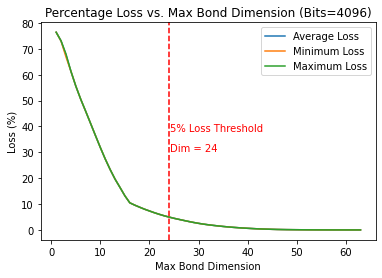

In [35]:
### BENCHMARKING COMPRESSION ###
dimensional_states = []
lower_bound_loss = []
avg_loss = []
upper_bound_loss = []
attempts = 3

# Try all bond dimensions under our raw state's max dimension
for bond_dim in range(1, int(d**np.floor(L/2))):
    max_sim = 0
    min_sim = 10e6
    sim_values = []
    
    # Number of compressed states to try to avoid local minima
    for i in range(attempts):
        # Initialize compressed state MPS of desired size
        compressed_state = initialize_random_state(L, bond_dim, phys_dim=d)
        
        # Decompose as input into sweep
        compressed_state, dist, sim = full_sweep(compressed_state, raw_state, threshold=1e-8)
        sim_values.append(sim[-1])

        # We want to save the min, avg, and max loss for a given bond dimension
        if sim[-1] > max_sim:
            max_sim = sim[-1]
        if sim[-1] < min_sim:
            min_sim = sim[-1]
    avg_loss.append(100*(1-np.mean(sim_values)))
    lower_bound_loss.append(100*(1-max_sim))
    upper_bound_loss.append(100*(1-min_sim))

# Plot loss vs. bond dimension and its bounds
plt.figure()
plt.title("Percentage Loss vs. Max Bond Dimension (Bits=%d)" %bits)
plt.xlabel("Max Bond Dimension")
plt.ylabel("Loss (%)")
plt.plot(range(1, len(avg_loss)+1), avg_loss, label='Average Loss')
plt.plot(range(1, len(avg_loss)+1), lower_bound_loss, label='Minimum Loss')
plt.plot(range(1, len(avg_loss)+1), upper_bound_loss, label='Maximum Loss')
plt.legend()

# Marker at index where we have less than 5% loss
try:
    index = next(x for x, value in enumerate(avg_loss) if value < 5)+1
    plt.axvline(index, color='r', linestyle='--')
    plt.text(index+0.1, max(avg_loss)/2, '5% Loss Threshold', color='r')
    plt.text(index+0.1, max(avg_loss)/2-0.1*max(avg_loss), 'Dim = %d' %index, color='r')
except:
    print("No loss better than 5%")

In [ ]:
### CREATION OF PLOTS FOR ANALYZING ONE SWEEP ###

# plot1 = plt.axes()
# plt.title("Mixed Canonical Raw State") 
# plt.xlabel("Update of site i")
# plt.ylabel("Similarity")

# plt.tight_layout()
# for i in range(10):
#     N   = 50
#     D = rand.randint(6, 15)
#     d = rand.randint(2, 5)

#     raw_state = initialize_random_state(N, D)
#     raw_state, _ = right_normalize(raw_state)  # Change this for normalization test, must be right for mixed canonical

#     initial_compressed_state = initialize_random_state(N, d)
#     compressed_state, dist, sim = sweep_L_to_R(initial_compressed_state, raw_state)

#     x = range(0, len(raw_state))    
#     plt.plot(x, sim, label="D = %d, d = %d" %(D, d))
#    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [21]:
### Scanning over possible raw states to check how closely a lower dimension state approximates it using one sweep ###
### Averaged over 50 random initial states to avoid local minima ###
# with open('one_sweep_tests.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["Points", "Raw Dim", "Compressed Dim", "Worst Similarity", "Best Similarity", "Worst Distance", "Best Distance"])

#     for N in range(3, 21):
#         # For checking progress
#         print(N)
#         for D in range(3, 21):
#             # Create a normalized state with bond dimension D
#             raw_state = initialize_random_state(numParticles = N, bondDim = D)
#             raw_state, _ = right_normalize(raw_state[:])
#             for d in range(2, D):
#                 # Check how close we can approximate it for all lower bond dimensions d
#                 best_sim = 0
#                 best_dist = 10e8
#                 worst_sim = 10e8
#                 worst_dist = 0

#                 # Averaged over 50 initial states
#                 for i in range(50):
#                     initial_compressed_state = initialize_random_state(numParticles = N, bondDim = d)
#                     try:  # In case of a singular matrix, we need to just generate a new state
#                         compressed_state, sim, dist = sweep_L_to_R(initial_compressed_state, raw_state)
#                     except:
#                         continue
#                     if sim > best_sim:
#                         best_sim = sim
#                     if sim < worst_sim:
#                         worst_sim = sim

#                     if dist < best_dist:
#                         best_dist = dist
#                     if dist > worst_dist:
#                         worst_dist = dist

#                 writer.writerow([N, D, d, worst_sim, best_sim, worst_dist, best_dist])

In [37]:
### CHECK THAT BOND CANONICAL PROPERLY CREATED ###
# test_identity = np.einsum('ij, ib->jb', A_tensors[0], A_tensors[0])
# print("Pos", "1", ":\n", test_identity)
# for i in range(1, len(A_tensors)):
#     # We contract left dimension and physical dimension for each site
#     # (d x d x 2)
#     test_identity = np.einsum('ijk, ibk->jb', A_tensors[i], A_tensors[i])
#     print("Pos", i+1, ":\n", test_identity)

# for i in range(0, len(B_tensors)-1):
#     # We contract right dimension and physical dimension for each site
#     test_identity = np.einsum('ijk, ajk->ia', B_tensors[i], B_tensors[i])
#     print("Pos", i+1+len(A_tensors), ":\n", test_identity)
# test_identity = np.einsum('ij, ib->jb', B_tensors[-1], B_tensors[-1])
# print("Pos", N, ":\n", test_identity)

In [38]:
### BOND CANONICAL WORKS FOR ALL BONDS ###
# for i in range(1, N-1):
#     A_tensors, B_tensors, lambda_bond = bond_canonical(gamma_tensors, lambda_tensors, bond=i)

In [39]:
### MANUAL CHECK A DECOMPOSITION ###
# if (A_tensors[0].all() != gamma_tensors[0].all()):
#     print("Error at tensor 0")
# for i in range(1, len(gamma_tensors)):
#     if i != len(gamma_tensors)-1:  # Inner tensors
#         A_recreated = np.einsum('ij, jbc->ibc', lambda_tensors[i-1], gamma_tensors[i])
#     else:
#         A_recreated = np.einsum('ij, aj->ia', lambda_tensors[-2], gamma_tensors[-1])
#     if (A_tensors[i].all() != A_recreated.all()):
#         print("Error at tensor", i)

In [40]:
### MANUAL CHECK B DECOMPOSITION ###
# if (B_tensors[-1].all() != gamma_tensors[-1].all()):
#     print("Error at tensor -1")
# for i in range(len(A_tensors), len(gamma_tensors)):
#     if i != len(gamma_tensors)-1:  # Inner tensors
#         B_recreated = np.einsum('ijk, jb->ibk', gamma_tensors[i], lambda_tensors[i])
#     if (B_tensors[i-len(A_tensors)].all() != B_recreated.all()):
#         print("Error at tensor", i)

In [41]:
# ### MANUAL CHECK NORM #####
# temp0 = np.einsum('ij, ib->jb', MPS[0], MPS[0])
# temp0 = np.reshape(temp0, (MPS[0].shape[1]**2))

# norm = temp0
# for i in range(1, len(MPS)-1):
#     temp = np.einsum('ijk, abk->iajb', MPS[i], MPS[i])
#     temp = np.reshape(temp, (MPS[i].shape[0]**2, MPS[i].shape[1]**2))
#     norm = np.einsum('i, ij->j', norm, temp)
# temp = np.einsum('ij, ib->jb', MPS[-1], MPS[-1])
# temp = np.reshape(temp, (MPS[-1].shape[1]**2))
# norm = np.einsum('i, i', norm, temp)
# print(np.sqrt(norm))

In [20]:
######################## EXPECTATION VALUE #############################################
# E_D_R = calculate_expectation(MPS, MPO, MPS, 'down', 'right')
# E_D_L = calculate_expectation(MPS, MPO, MPS, 'down', 'left')
# E_U_R = calculate_expectation(MPS, MPO, MPS, 'up', 'right')
# E_U_L = calculate_expectation(MPS, MPO, MPS, 'up', 'left')

# # Rounding necessary since sometimes the values are slightly off
# # Most likely due to rounding errors in computation
# if (np.round(E_D_R, 5) == np.round(E_D_L, 5)
#                        == np.round(E_U_R, 5)
#                        == np.round(E_U_L, 5)):
#     print("Expectation value is the same in all directions")
# print(E_D_R, E_D_L, E_U_R, E_U_L)

In [23]:
# # ####### CONTRACT HAMILTONIAN LEFT AND RIGHT ########
# temp = contract_horizontal(MPO[0], MPO[1], 'right')
# H_right = contract_horizontal(temp, MPO[2], 'right')
# temp = contract_horizontal(MPO[2], MPO[1], 'left')
# H_left = contract_horizontal(temp, MPO[0], 'left')
# if (H_right.all() == H_left.all()):
#     print("Hamiltonian contracts correctly")

In [24]:
# # ######## EXPECTATION VALUE DOWN, RIGHT ##########
# # Left lattice bra->H->ket
# temp = contract_vertical(MPS[0], MPO[0], 'down')
# left = contract_vertical(temp, MPS[0], 'down')

# # Inner lattice bra->H->ket
# temp = contract_vertical(MPS[1], MPO[1], 'down')
# inner = contract_vertical(temp, MPS[1], 'down')

# # Right lattice bra->H->ket
# temp = contract_vertical(MPS[2], MPO[2], 'down')
# right = contract_vertical(temp, MPS[2], 'down')

# temp = contract_horizontal(left, inner, 'right')
# E_down_right = contract_horizontal(temp, right, 'right')

# ###### EXPECTATION VALUE UP, RIGHT ###########
# # Left lattice ket->H->bra
# temp = contract_vertical(MPS[0], MPO[0], 'up')
# left = contract_vertical(temp, MPS[0], 'up')

# # Inner lattice ket->H->bra
# temp = contract_vertical(MPS[1], MPO[1], 'up')
# inner = contract_vertical(temp, MPS[1], 'up')

# # Right lattice ket->H->bra
# temp = contract_vertical(MPS[2], MPO[2], 'up')
# right = contract_vertical(temp, MPS[2], 'up')

# temp = contract_horizontal(left, inner, 'right')
# E_up_right = contract_horizontal(temp, right, 'right')

# ###### EXPECTATION VALUE UP, LEFT ###########
# # Right lattice bra->H->ket
# temp = contract_vertical(MPS[2], MPO[2], 'up')
# right = contract_vertical(temp, MPS[2], 'up')

# # Inner lattice bra->H->ket
# temp = contract_vertical(MPS[1], MPO[1], 'up')
# inner = contract_vertical(temp, MPS[1], 'up')

# # Left lattice bra->H->ket
# temp = contract_vertical(MPS[0], MPO[0], 'up')
# left = contract_vertical(temp, MPS[0], 'up')

# temp = contract_horizontal(right, inner, 'left')
# E_up_left = contract_horizontal(temp, left, 'left')

# ###### EXPECTATION VALUE DOWN, LEFT ###########
# # Right lattice bra->H->ket
# temp = contract_vertical(MPS[2], MPO[2], 'down')
# right = contract_vertical(temp, MPS[2], 'down')

# # Inner lattice bra->H->ket
# temp = contract_vertical(MPS[1], MPO[1], 'down')
# inner = contract_vertical(temp, MPS[1], 'down')

# # Left lattice bra->H->ket
# temp = contract_vertical(MPS[0], MPO[0], 'down')
# left = contract_vertical(temp, MPS[0], 'down')

# temp = contract_horizontal(right, inner, 'left')
# E_down_left = contract_horizontal(temp, left, 'left')

# ######## EXPECTATION VALUE ZIG-ZAG ##########
# # Left lattice bra->H->ket
# temp = contract_vertical(MPS[0], MPO[0], 'down')
# left = contract_vertical(temp, MPS[0], 'down')

# # Inner lattice ket->H->bra
# temp = contract_vertical(MPS[1], MPO[1], 'up')
# inner = contract_vertical(temp, MPS[1], 'up')

# # Right lattice bra->H->ket
# temp = contract_vertical(MPS[2], MPO[2], 'down')
# right = contract_vertical(temp, MPS[2], 'down')

# temp = contract_horizontal(left, inner, 'right')
# E_zig_zag = contract_horizontal(temp, right, 'right')

# if (E_down_right.all() == E_down_left.all() == E_up_right.all() == E_up_left.all() == E_zig_zag.all()):
#      print("Expectation value contracts in all directions correctly")